In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for a simple 1D Richards equation solver using Picard iteration
# Picard iteration parameters
max_iter = 10  # maximum number of Picard iterations
tol = 1e-6  # convergence tolerance

# Updated parameters
zmax = 1000.0  # length of the domain in cm 
dz = 5.0
z = np.arange(dz/2,zmax,dz)  # spatial step size (5 cm increments)
Nz = z.size

t0 = 0.0
tf = 2000  # [hr] duration of run 
dt = 0.25  # [hr] larger time step in days for computational efficiency
t = np.arange(t0,tf,dt)
Nt = t.size

# Soil hydraulic parameters (simplified)
theta_r = 0.05      # residual water content
theta_s = 0.45     # saturated water content
alpha = 0.03       # parameter (1/m)
n = 2.5            # parameter for soil water retention curve
Ks = 0.72e-3*3600  # saturated hydraulic conductivity (cm/hr)

g = 12713760000 # gravitational acceleration in cm/hr^2

# Boundary conditions
theta0 = theta_r + 0.2  # initial water content
theta_top = theta_s  # water content at surface
theta_bottom = theta_r  # water content at the bottom

# Discretized domain
theta = np.ones(Nz) * theta0
theta_new = np.zeros(Nz)

In [18]:
# Functions for hydraulic properties
def theta_h(h, alpha, n, theta_r, theta_s):
    Se = 1 / (1 + (alpha * h)**n)**(1 - 1/n)
    return theta_r + Se * (theta_s - theta_r)

def h_theta(theta, alpha, n, theta_r, theta_s):
    Se = (theta - theta_r) / (theta_s - theta_r)
    h = (1 / alpha) * ((Se**(-1/(1 - 1/n))) - 1)**(1/n)
    return h

def K(h, Ks, alpha, n):
    Se = 1 / (1 + (alpha * h)**n)**(1 - 1/n)
    return Ks * Se**0.5 * (1 - (1 - Se**(n / (n - 1)))**(1 - 1/n))**2

def C(h, alpha, n, theta_r, theta_s):
    return (alpha * (1 + (alpha * h)**n)**(-1 + 1/n)) * (theta_s - theta_r)

# Simple time loop with Picard iteration
# Function to handle free drainage at the bottom boundary (zero gradient)
def richards_solver_free_drainage(theta, Nz, dz, Nt, dt):
    theta_new = np.copy(theta)
    Theta = np.zeros((Nt, Nz))  # Array to store water content at each timestep
    for t in range(Nt):
        for picard_iter in range(max_iter):
            theta_old = np.copy(theta_new)  # Store old values for convergence check
            for i in range(1, Nz - 1):
                # Calculate hydraulic head
                h_old = h_theta(theta_new[i], alpha, n, theta_r, theta_s)
                
                # Calculate the total hydraulic head (h_total = h_m + z) and the flux
                h_total_old = h_old + z[i] / 100  # adding gravitational head
                
                # Calculate the hydraulic conductivity
                K_val = K(h_old, Ks, alpha, n)

                # Update the water content using the total flux (capillarity + gravity)
                flux_in = K_val * ((h_total_old - h_total_old) - (theta_new[i] - theta_new[i - 1])) / dz
                flux_out = K_val * (theta_new[i] - theta_new[i + 1]) / dz + g * dt
                
                theta_new[i] += dt * (flux_in - flux_out) / dz

            # Check for convergence (max difference between old and new values)
            if np.max(np.abs(theta_new - theta_old)) < tol:
                break

        # Apply boundary conditions
        theta_new[0] = theta_top  # Dirichlet BC at the surface
        # Free drainage at the bottom: zero flux condition (d(theta)/dz = 0)
        theta_new[-1] = theta_new[-2]
        
        # Save theta at each time step
        Theta[t, :] = theta_new
        
    return Theta




In [19]:
p = 50

# Initial water content profile
theta = np.ones(Nz) * theta0

# Run the solver with the new settings and save the results in Theta
Theta = richards_solver_free_drainage(theta, Nz, dz, Nt, dt)



/var/folders/1k/mbw42lf14zx98ylfyw3rythr6_jghh/T/ipykernel_84954/966770423.py:8: RuntimeWarning: invalid value encountered in scalar power
  h = (1 / alpha) * ((Se**(-1/(1 - 1/n))) - 1)**(1/n)


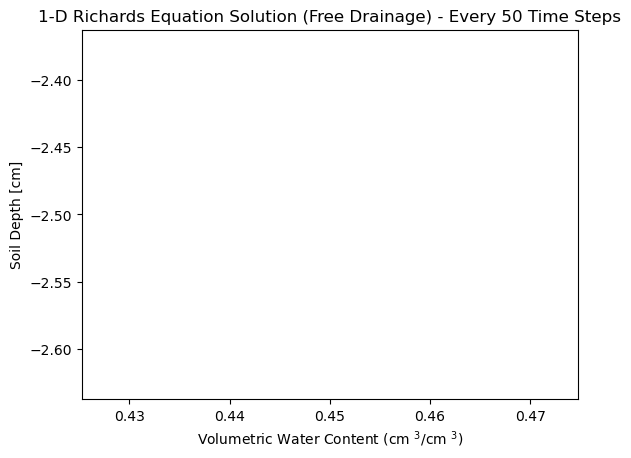

In [20]:
# Customize and show the plot
plt.xlabel("Volumetric Water Content (cm ${}^3$/cm ${}^3$)")
plt.ylabel("Soil Depth [cm]")
for t in np.arange(0,Nt,p):
    if t % p == 0:
        plt.plot(Theta[t,:],-z, 'b-')
plt.title("1-D Richards Equation Solution (Free Drainage) - Every 50 Time Steps")
plt.show()